In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [2]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [3]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n

def expE(nbar, omega, Ncut):
    expE = 0.0
    #Ncut = 1001
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def expEHeat(nbar0, nbarf, omega, Ncut):
    return expE((nbar0+nbarf)/2.0, omega, Ncut)

hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
beta = 0.0
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)

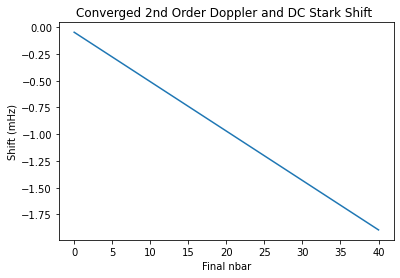

In [11]:
pts = 10
nbarfs = np.linspace(0, 40, pts)
Ncut = 1201
nbar0 = 0.0
shifts = -expEHeat(nbar0, nbarfs, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
plt.plot(nbarfs,shifts*nu0*1.0e3, label="Ncut=1201")
plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")
plt.title("Converged 2nd Order Doppler and DC Stark Shift ")
plt.show()

In [5]:
def HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(thermPulse(freeEvo@pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(thermPulse(freeEvo@pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [20]:
Ncut = 601
qs = np.array([0.9, 0.8, 0.7])
psi0 = psi(0.0, 1.0)
Delta = 0.23 #*2.0*np.pi #hz
Omega0 = 20.0*2.0*np.pi #hz
nbar0 = 0.0 
t1 = np.pi/(2.0*Omega0)
t2 = 3.0*np.pi/(2.0*Omega0)
T = 50.0e-3
eta = 0.05
shifts2 = np.zeros([np.size(qs), pts])

tol = 1.0e-11
guessTol = 5.0

for ii in range(np.size(qs)):
    print(qs[ii])
    x0 = -0.1
    x1 = 0.5
    for jj in range(pts):
        print(nbarfs[jj])
        shifts2[ii][jj] = sp.optimize.root_scalar(HRJumpThermErrSig, args=(psi0, t1, T, t2, Delta, Omega0*qs[ii], eta, nbar0, nbarfs[jj], Ncut), bracket=[x0,x1], xtol = tol).root
        #print(shifts1[ii])
        x0 = shifts2[ii][jj] - guessTol
        x1 = shifts2[ii][jj] + guessTol
        #print(x0,x1)

0.9
0.0
4.444444444444445
8.88888888888889
13.333333333333334
17.77777777777778
22.22222222222222
26.666666666666668
31.111111111111114
35.55555555555556
40.0
0.8
0.0
4.444444444444445
8.88888888888889
13.333333333333334
17.77777777777778
22.22222222222222
26.666666666666668
31.111111111111114
35.55555555555556
40.0
0.7
0.0
4.444444444444445
8.88888888888889
13.333333333333334
17.77777777777778
22.22222222222222
26.666666666666668
31.111111111111114
35.55555555555556
40.0


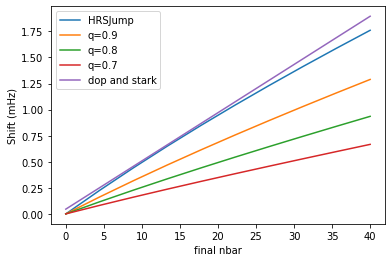

In [21]:
plt.plot(nbarfs, shifts1*1e3, label="HRSJump")
plt.plot(nbarfs, shifts2[0,:]*1e3, label="q=0.9")
plt.plot(nbarfs, shifts2[1,:]*1e3, label="q=0.8")
plt.plot(nbarfs, shifts2[2,:]*1e3, label="q=0.7")
plt.plot(nbarfs,-shifts*nu0*1.0e3, label="dop and stark")
plt.xlabel("final nbar")
plt.ylabel("Shift (mHz)")
plt.legend()
plt.show()

#plt.plot(nbarfs,(shifts1+shifts*nu0)*1e3, label="HRSJump")
